In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from scipy import stats
agw2017 = pd.read_stata("agw2017")
agw2013 = pd.read_stata("agw2013")
agw2007 = pd.read_stata("agw2007")

gez2017 = pd.read_stata("gez2017")
gez2013 = pd.read_stata("gez2013")
gez2007 = pd.read_stata("gez2007")




Vragenlijst Wonen en Hypotheken
B26Og eigenaar van woning (1=ja, 0=nee)
B26Hy hypotheken op de woning
B26Vz cash value levensverzekering hypotheek woning
B27Og eigenaar van tweede woning (1=ja, 0=nee)
B27Hy hypotheken op tweede woning
B27Vz cash value levensverzekering hypotheek tweede woning

### Eerst maak ik de Net-worth variabele

Dit doe ik dmv een functie die alle bezittingen (b1b, b2b, ..., b30b) bij elkaar optelt en daar de schulden (s1b, s2b, ..., s8b, x1b) vanaf trekt.

In [3]:
def calcWealth(row):
    wealth = (row["b1b"] + row["b2b"] + row["b3b"] + row["b4b"] + row["b6b"] + row["b7b"] + row["b8b"] + row["b11b"]
              + row["b12b"] + row["b13b"] + row["b14b"] + row["b15b"] + row["b16b"] + row["b17b"] + row["b18b"] + 
             row["b19ogb"] + row["b19hyb"] + row["b19vzb"] + row["b20b"] + row["b21b"] + row["b22b"] + row["b23b"] +
             row["b24b"] + row["b25b"] + row["b28b"] + row["b29b"] + row["b30b"])
    # Door te checken of b26ogb > -1 zorg ik dat enkel rows zonder NaN hier worden gebruikt. Ze zijn of volledig Nan of niet
    if row["b26ogb"] > -1:
        wealth += row["b26ogb"] + row["b26vzb"] + row["b27ogb"] + row["b27vzb"]
    return wealth

In [17]:
def calcDebt(row):
    debt = (row["s1b"] + row["s2b"] + row["s3b"] + row["s4b"] + row["s5b"] + row["s6b"] + row["s7b"] + row["s8b"] +
           row["x1b"]) 
    # Door te checken of b26ogb > -1 zorg ik dat enkel rows zonder NaN hier worden gebruikt. Ze zijn of volledig Nan of niet
    if row["b26ogb"] > -1:
        debt += row["b26hyb"] + row["b27hyb"]
    
    return debt

In [18]:
def calcNetWorth(row):
    netWorth = row["wealth"] - row["debt"]
    return netWorth

In [19]:
agw2017["debt"] = agw2017.apply(calcDebt, axis = 1)
agw2013["debt"] = agw2013.apply(calcDebt, axis = 1)
agw2007["debt"] = agw2007.apply(calcDebt, axis = 1)




In [20]:
agw2017["wealth"] = agw2017.apply(calcWealth, axis = 1)
agw2013["wealth"] = agw2013.apply(calcWealth, axis = 1)
agw2007["wealth"] = agw2007.apply(calcWealth, axis = 1)



In [24]:
agw2017["netWorth"] = agw2017.apply(calcNetWorth, axis = 1)
agw2013["netWorth"] = agw2013.apply(calcNetWorth, axis = 1)
agw2007["netWorth"] = agw2007.apply(calcNetWorth, axis = 1)

In [8]:
# Counter om aantal positieve en negatieve networths te tellen
pos = 0
neg = 0
zero = 0

# Arrays om de negatieven en positieven networths bij te houden
negatives = []
positives = []

# Bepaald voor iedere row of de networth positief of negatief is en zet deze waarde in een array
for x in range(0, agw.shape[0] - 1):
    if agw.loc[x,"netWorth"] > 0:
        positives.append(agw.loc[x, "netWorth"])
        pos += 1
    elif agw.loc[x, "netWorth"] < 0:
        negatives.append(agw.loc[x, "netWorth"])
        neg += 1
    else:
        zero += 1
        
print("aantal positieve networth: " + str(pos) +  " aantal negatieve networth: " + str(neg))
print("aantal met net worth nul (waarschijnlijk lege entries): " + str(zero))

aantal positieve networth: 2054 aantal negatieve networth: 223
aantal met net worth nul (waarschijnlijk lege entries): 81


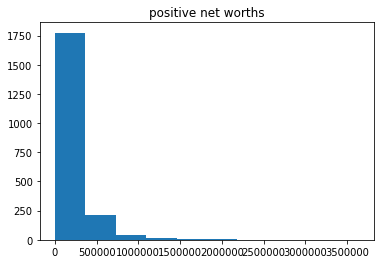

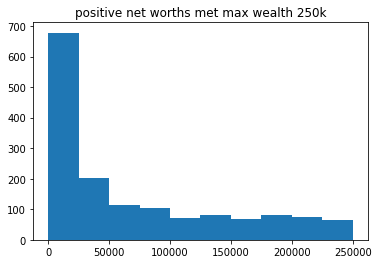

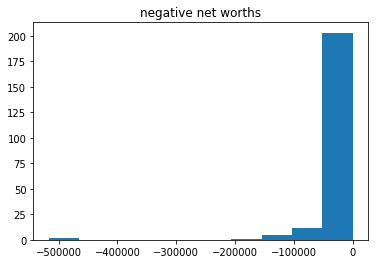

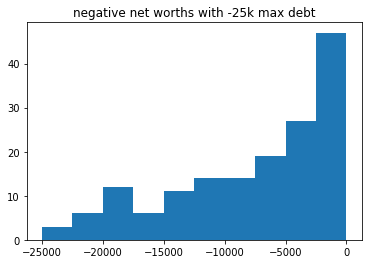

In [10]:


negatives.sort()
positives.sort()

plt.hist(positives)
plt.title("positive net worths")
plt.show()

plt.hist(positives, range = (0, 250000))
plt.title("positive net worths met max wealth 250k")
plt.show()

plt.hist(negatives)
plt.title("negative net worths")
plt.show()

plt.hist(negatives, range = (-25000, 0))
plt.title("negative net worths with -25k max debt")
plt.show()





# Hier boven:

het feit dat bezit tot 10x zo veel gaat als schuld, kan leiden tot ene verschil in effect op  gezondheid (bijvoorbeeld 10x minder sterk oid) Misschien hier nog iets mee doen!

In [31]:
merged2017 = pd.merge(gez2017, agw2017, on = "personid")
merged2013 = pd.merge(gez2013, agw2013, on = "personid")
merged2007 = pd.merge(gez2007, agw2007, on = "personid")


In [37]:
merged = pd.merge(merged2017, merged2013, on = "personid")
merged = pd.merge(merged, merged2007, on = "personid")


In [38]:
print(merged.shape)

(537, 426)


In [45]:
def selfAssedHealth(row):
    healthValues = {"Excellent" : 1, "Good" : 1, "Fair" : 1,
                 "Not so good" : 0, "Poor": 0, "excellent" : 1, "good" : 1, "fair" : 1, "not so good" : 0, "poor" : 0} 
    
    return healthValues[row["gez3"]]


http://www.statsmodels.org/stable/discretemod.html

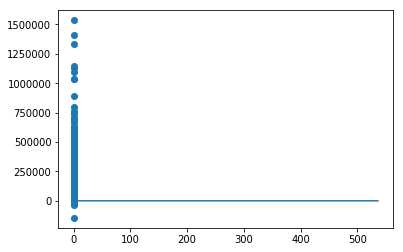

In [52]:
merged["selfAssedHealth"] = merged.apply(selfAssedHealth, axis = 1)
plt.scatter(merged.selfAssedHealth, merged.netWorth)
merged2017["selfAssedHealth"] = merged2017.apply(selfAssedHealth, axis = 1)
merged2013["selfAssedHealth"] = merged2013.apply(selfAssedHealth, axis = 1)
merged2007["selfAssedHealth"] = merged2007.apply(selfAssedHealth, axis = 1)







In [49]:
result = sm.ols(formula="selfAssedHealth ~ netWorth", data=merged).fit()
print(result.summary())

In [54]:
result = sm.ols(formula="selfAssedHealth ~ netWorth", data=merged2017).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        selfAssedHealth   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     11.00
Date:                Mon, 07 Jan 2019   Prob (F-statistic):           0.000927
Time:                        16:52:02   Log-Likelihood:                 127.40
No. Observations:                2215   AIC:                            -250.8
Df Residuals:                    2213   BIC:                            -239.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9347      0.006    164.335      0.0

In [55]:
result = sm.ols(formula="selfAssedHealth ~ netWorth", data=merged2013).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        selfAssedHealth   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1105
Date:                Mon, 07 Jan 2019   Prob (F-statistic):              0.740
Time:                        16:52:07   Log-Likelihood:                 257.21
No. Observations:                1649   AIC:                            -510.4
Df Residuals:                    1647   BIC:                            -499.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9562      0.006    157.627      0.0

In [56]:
result = sm.ols(formula="selfAssedHealth ~ netWorth", data=merged2007).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        selfAssedHealth   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4171
Date:                Mon, 07 Jan 2019   Prob (F-statistic):              0.518
Time:                        16:52:23   Log-Likelihood:                 327.95
No. Observations:                1809   AIC:                            -651.9
Df Residuals:                    1807   BIC:                            -640.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9558      0.005    177.289      0.0

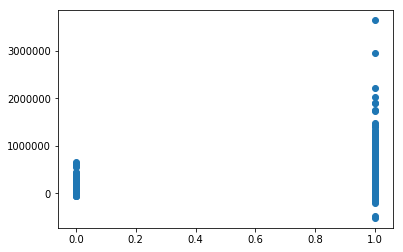

In [58]:
plt.scatter(merged2017.selfAssedHealth, merged2017.netWorth)

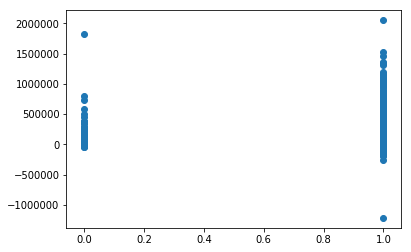

In [59]:
plt.scatter(merged2013.selfAssedHealth, merged2013.netWorth)

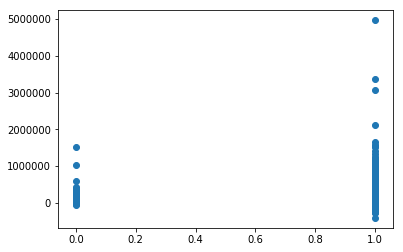

In [60]:
plt.scatter(merged2007.selfAssedHealth, merged2007.netWorth)

In [ ]:
merged.to_stata("merged_data.dta")

In [ ]:
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


In [20]:
print(merged)

      index_x  nohhold_x  nomem_x    weeknr   gez1   gez2         gez3  \
0           0        6.0      1.0  201718.0  176.0   97.0         Good   
1           1       21.0      1.0  201717.0  175.0   92.0         Good   
2           2       38.0      1.0  201717.0  157.0   76.0         Good   
3           3      106.0      1.0  201717.0  182.0   99.0         Good   
4           4      173.0      1.0  201717.0  193.0   97.0    Excellent   
5           5      175.0      1.0  201718.0  176.0   82.0         Fair   
6           6      262.0      2.0  201717.0  182.0   84.0         Good   
7           7      268.0      1.0  201717.0  168.0   80.0    Excellent   
8           8      338.0      2.0  201717.0  172.0   84.0         Good   
9           9      339.0      2.0  201717.0  167.0   75.0         Fair   
10         10      371.0      1.0  201717.0  176.0   82.0         Good   
11         11      423.0      1.0  201717.0  175.0   68.0         Good   
12         12      461.0      1.0  201